In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sns.set_theme()

In [67]:
import os

PLOT_DIR = "example-plots"

if not(os.path.exists(PLOT_DIR)):
    os.mkdir(PLOT_DIR)

In [68]:
# Load data
# results_file = "result-1625148829-all.csv"
# results_file = "result-1624554975-all-exec.csv"
results_file = "20210910-113516.csv"
df_raw = pd.read_csv(f"results/{results_file}")

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Benchmark                 282 non-null    object 
 1   Mode                      282 non-null    object 
 2   Threads                   282 non-null    int64  
 3   Samples                   282 non-null    int64  
 4   Score                     282 non-null    float64
 5   Score Error (99.9%)       282 non-null    float64
 6   Unit                      282 non-null    object 
 7   Param: metaborgVersion    282 non-null    object 
 8   Param: optimisationLevel  282 non-null    int64  
 9   Param: problemSize        282 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 22.2+ KB


In [69]:
for col in ["Score", "Score Error (99.9%)"]:
    if df_raw[col].dtype == object:
        df_raw[col] = df_raw[col].map(lambda s: s.replace(',', '.'), na_action="ignore").astype(float)

# df_raw

In [70]:
df_raw["Param: optimisationLevel"] = df_raw["Param: optimisationLevel"].astype("string")

In [135]:
df = df_raw[df_raw.Benchmark.str.endswith("jfr") == False].copy()
df

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize
0,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,15,0.352905,0.089334,s/op,2.6.0-SNAPSHOT,2,10
1,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,15,0.353537,0.095412,s/op,2.6.0-SNAPSHOT,2,11
2,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,15,0.368083,0.109985,s/op,2.6.0-SNAPSHOT,2,12
3,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,15,0.370350,0.084137,s/op,2.6.0-SNAPSHOT,2,13
4,benchmark.stratego2.compilation.java.Benchexpr...,ss,1,15,0.352538,0.093805,s/op,2.6.0-SNAPSHOT,2,14
...,...,...,...,...,...,...,...,...,...,...
277,benchmark.stratego2.execution.Hanoi.run,ss,1,15,1.693099,0.014060,s/op,2.6.0-SNAPSHOT,4,10
278,benchmark.stratego2.execution.Hanoi.run,ss,1,15,3.393445,0.297794,s/op,2.6.0-SNAPSHOT,4,11
279,benchmark.stratego2.execution.Quicksort.run,ss,1,15,0.833775,0.006774,s/op,2.6.0-SNAPSHOT,2,10
280,benchmark.stratego2.execution.Quicksort.run,ss,1,15,0.846598,0.050855,s/op,2.6.0-SNAPSHOT,3,10


In [136]:
df["Stage"] = df["Benchmark"].str.rpartition('.')[2]
df["Problem"] = df["Benchmark"].str.split('.').map(lambda l: l[-2])

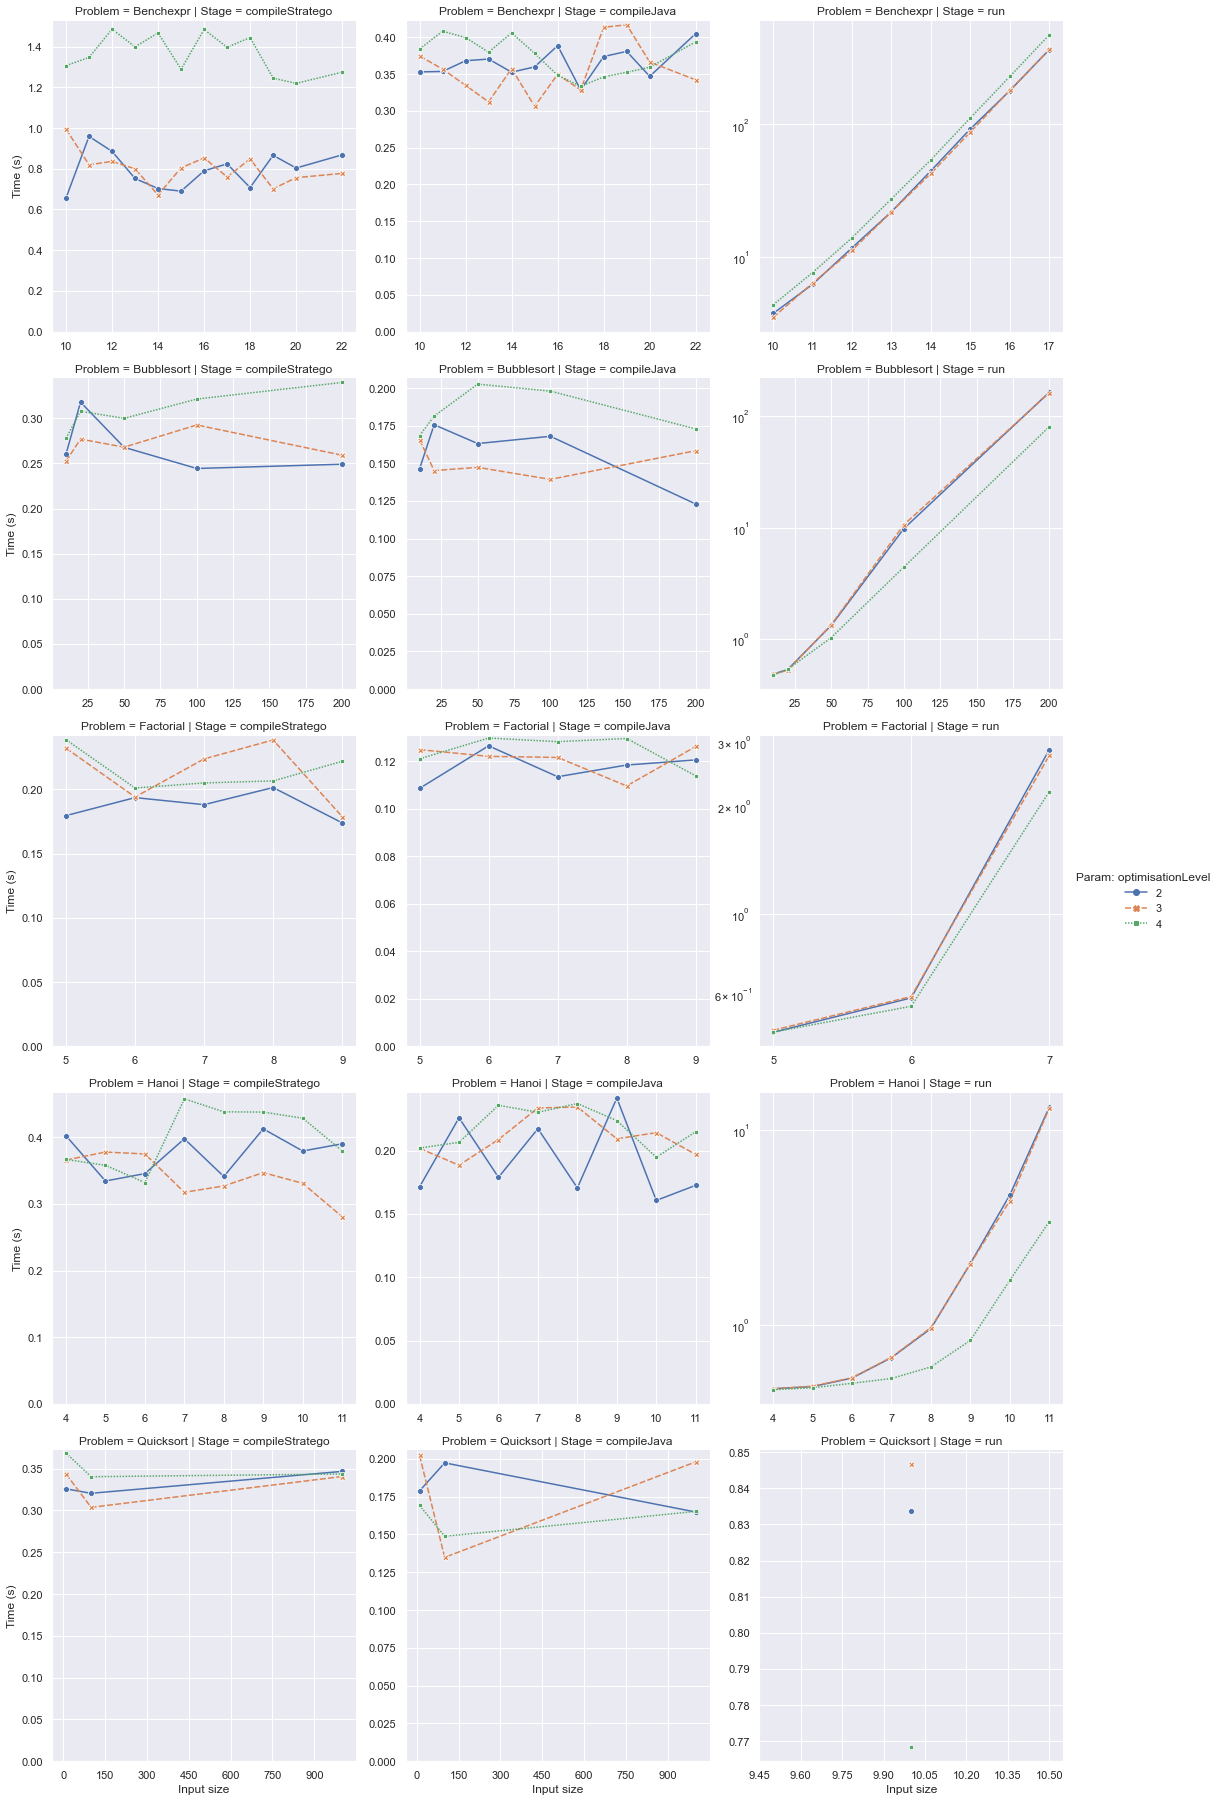

In [137]:
df_scaledproblem = df[df["Param: problemSize"] != -1]

g = sns.relplot(
    data=df_scaledproblem,
    x="Param: problemSize",
    y="Score",
    row="Problem",
    col="Stage",
    col_order=["compileStratego", "compileJava", "run"],
    style="Param: optimisationLevel",
    hue="Param: optimisationLevel",
    hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
)

# TODO Include strj runtime -> with and without fusion


## Global settings
g.set_ylabels("Time (s)")
g.set_xlabels("Input size")
for axs in g.axes:
    for ax in axs:
        ax.get_xaxis().set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

## Plot-specific settings
configs = [
    {
        "problems": ["Benchexpr", "Bubblesort", "Factorial", "Hanoi"],
        "stages": ["run"],
        "settings": {"yscale": "log"}
    },
    {
        # Apply to all problems
        "stages": ["compileStratego", "compileJava"],
        "settings": {"ylim": (0, None)}
    }
]

for (row_val, col_val), ax in g.axes_dict.items():
    for config in configs:
        if "problems" not in config or row_val in config["problems"]:
            if "stages" not in config or col_val in config["stages"]:
                ax.set(**config["settings"])


# Save figure to file
plt.savefig(f"example-plots/{results_file}-scaled.png", transparent=False)

In [134]:
df_unscaledproblem = df[df["Param: problemSize"] == -1]
df_unscaledproblem
# plt.savefig(f"example-plots/{results_file}-unscaled.png", transparent=False)

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize,Stage,Problem
51,benchmark.stratego2.compilation.java.Calls.com...,ss,1,15,0.163966,0.019335,s/op,2.6.0-SNAPSHOT,2,-1,compileJava,Calls
52,benchmark.stratego2.compilation.java.Calls.com...,ss,1,15,0.174358,0.053946,s/op,2.6.0-SNAPSHOT,3,-1,compileJava,Calls
53,benchmark.stratego2.compilation.java.Calls.com...,ss,1,15,0.204909,0.115745,s/op,2.6.0-SNAPSHOT,4,-1,compileJava,Calls
153,benchmark.stratego2.compilation.stratego.Calls...,ss,1,15,0.221330,0.045572,s/op,2.6.0-SNAPSHOT,2,-1,compileStratego,Calls
154,benchmark.stratego2.compilation.stratego.Calls...,ss,1,15,0.212249,0.023688,s/op,2.6.0-SNAPSHOT,3,-1,compileStratego,Calls
155,benchmark.stratego2.compilation.stratego.Calls...,ss,1,15,0.225680,0.067583,s/op,2.6.0-SNAPSHOT,4,-1,compileStratego,Calls
243,benchmark.stratego2.execution.Calls.run,ss,1,15,0.437678,0.005309,s/op,2.6.0-SNAPSHOT,2,-1,run,Calls
244,benchmark.stratego2.execution.Calls.run,ss,1,15,0.433323,0.003255,s/op,2.6.0-SNAPSHOT,3,-1,run,Calls
245,benchmark.stratego2.execution.Calls.run,ss,1,15,0.434602,0.004061,s/op,2.6.0-SNAPSHOT,4,-1,run,Calls
